# Historical Data: Intraday

These financial data are generally provided in a format that includes the following information:  
Date  
Open Price  
High Price  
Low Price  
Closing Price  
Volume
These data—often referred to as OHLC Chart Data—can be interpreted as Time Series data and are perfect for performing technical analysis. We’ll dive into this format in just a moment but, for now, just realize this is a standard format for historical pricing data within financial markets.

## Import libraries

In [27]:
import yfinance as yf
import os
import pandas as pd
from matplotlib import pyplot as plt
from io import StringIO
import requests
import seaborn as sns

## Extracting ticker codes
Extracting ticker codes of yfinance and EODhistoricaldata of same companies.

In [6]:
'''Extracting ticker of eodhistoricaldata.'''
api_key = '6327e5ab358c70.29416475'

class NoSuchExchange(Exception):
    def __init__(self, message: str= "No such exhange supported."):
        self.message = message
        super().__init__(message)

def get_ticker_list(exchange, api_token, session=None):

    if exchange not in ['BSE', 'NSE']:
        raise NoSuchExchange()
    
    if session is None:
        session=requests.Session()
        url = 'https://eodhistoricaldata.com/api/exchange-symbol-list/%s' % exchange
        params = {'api_token': api_token}
        r = session.get(url, params=params)
    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df

In [15]:
file = 'Yahoo Ticker Symbols - September 2017.xlsx'
df = pd.read_excel(os.path.abspath(file), sheet_name='Stock')
ticker_list1 = get_ticker_list('BSE', api_key)
name_list=ticker_list1['Name']
df_BSE = df[df['Unnamed: 2'] == 'BSE']
ticker = df_BSE[df_BSE['Unnamed: 1'].isin(name_list)].head(30)
extra_name = ticker_list1[ticker_list1['Name'].isin(ticker['Unnamed: 1'])].reset_index()
yfinance_ticker = ticker['Yahoo Stock Tickers'].reset_index(drop=True)
yfinance_company = ticker['Unnamed: 1'].reset_index(drop=True)
eod_ticker = extra_name['Code'].reset_index(drop=True)
eod_company = extra_name['Name'].reset_index(drop=True)

## Download yfinance historical data

In [16]:
# download historical data of yfinance
yfinance_dict = {}
for i in range(30):
    yfinance_dict[yfinance_company[i]] = yf.download(yfinance_ticker[i], period='max')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Extract EODHistoricaldata

In [11]:
def get_eod_data(symbol, api_token="xxxx", session=None):
    '''returns a df of historical data.'''
    if session is None:
        session = requests.Session()
        url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
        params = {"api_token": api_token}
        r = session.get(url, params=params)

    if r.status_code == requests.codes.ok:
        df = pd.read_csv(StringIO(r.text), skipfooter=0, parse_dates=[0], index_col=0, engine='python')
        return df


In [17]:
api_key = '6327e5ab358c70.29416475'
eod_dict = {}
for i in range(29):
    eod_dict[eod_company[i]] = get_eod_data(eod_ticker[i]+'.BSE', api_key)

## Data Preprocessing
Checking is data contains null, duplicate values or not and data contains any outliers or not.

In [1]:
# Checking if data contains any outliers
def find_outliers(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return pd.DataFrame(outliers)

def data_preprocessing(df):
    null_values = df.isna().sum()                      # checking if data contains any null values
    duplicate_values = df.duplicated()                 # checking if data contains any duplicate values
    common_stats = df.describe()                       # checking common stats of data
    outliers = find_outliers(df)                       # finding outliers in data

    dict = {'null_values':null_values, 'duplicate_values':duplicate_values, 'common_stats':common_stats, 'outliers':outliers}
    return dict

In [383]:
"""Checking EOD and yfinance Data. """
data_preprocessing_eod = {}
data_preprocessing_yfinance = {}
for company in eod_dict.keys():
    data_preprocessing_eod[company] = data_preprocessing(eod_dict[company])
    data_preprocessing_yfinance[company] = data_preprocessing(yfinance_dict[company])

In [ ]:
data_preprocessing_eod

In [ ]:
data_preprocessing_yfinance

## Data wrangling
Finding differences in data and combining open, close, high, low and volume values of different companies together.

In [24]:
difference_in_data = {}
for company in eod_company:
    try:
        difference_in_data[company] = (eod_dict[company] - yfinance_dict[company])
        difference_in_data[company]['date'] = pd.to_datetime(difference_in_data[company].index)
        difference_in_data[company].set_index('date', inplace=True)
        difference_in_data[company].index = pd.to_datetime(difference_in_data[company].index)
        difference_in_data[company] = difference_in_data[company].resample('A').last()
    except KeyError as e:
        pass

res = pd.concat(difference_in_data.values(), axis=1, keys=difference_in_data.keys())

data_open = {}
data_close = {}
data_high = {}
data_low = {}
data_volume = {}
for company in difference_in_data.keys():
    data_open[company] = res[company]['Open']
    data_close[company] = res[company]['Close']
    data_high[company] = res[company]['High']
    data_low[company] = res[company]['Low']
    data_volume[company] = res[company]['Volume']

res_open = pd.DataFrame(data_open)
res_close = pd.DataFrame(data_close)
res_high = pd.DataFrame(data_high)
res_low = pd.DataFrame(data_low)
res_volume = pd.DataFrame(data_volume)

## Ploting the data
Let's plot the difference in the values of data provided by yfinance and EODhistorical of 30 companies.

### Line plot
Line plot of open, close, low, high and volume columns of 30 companies of yearly data.

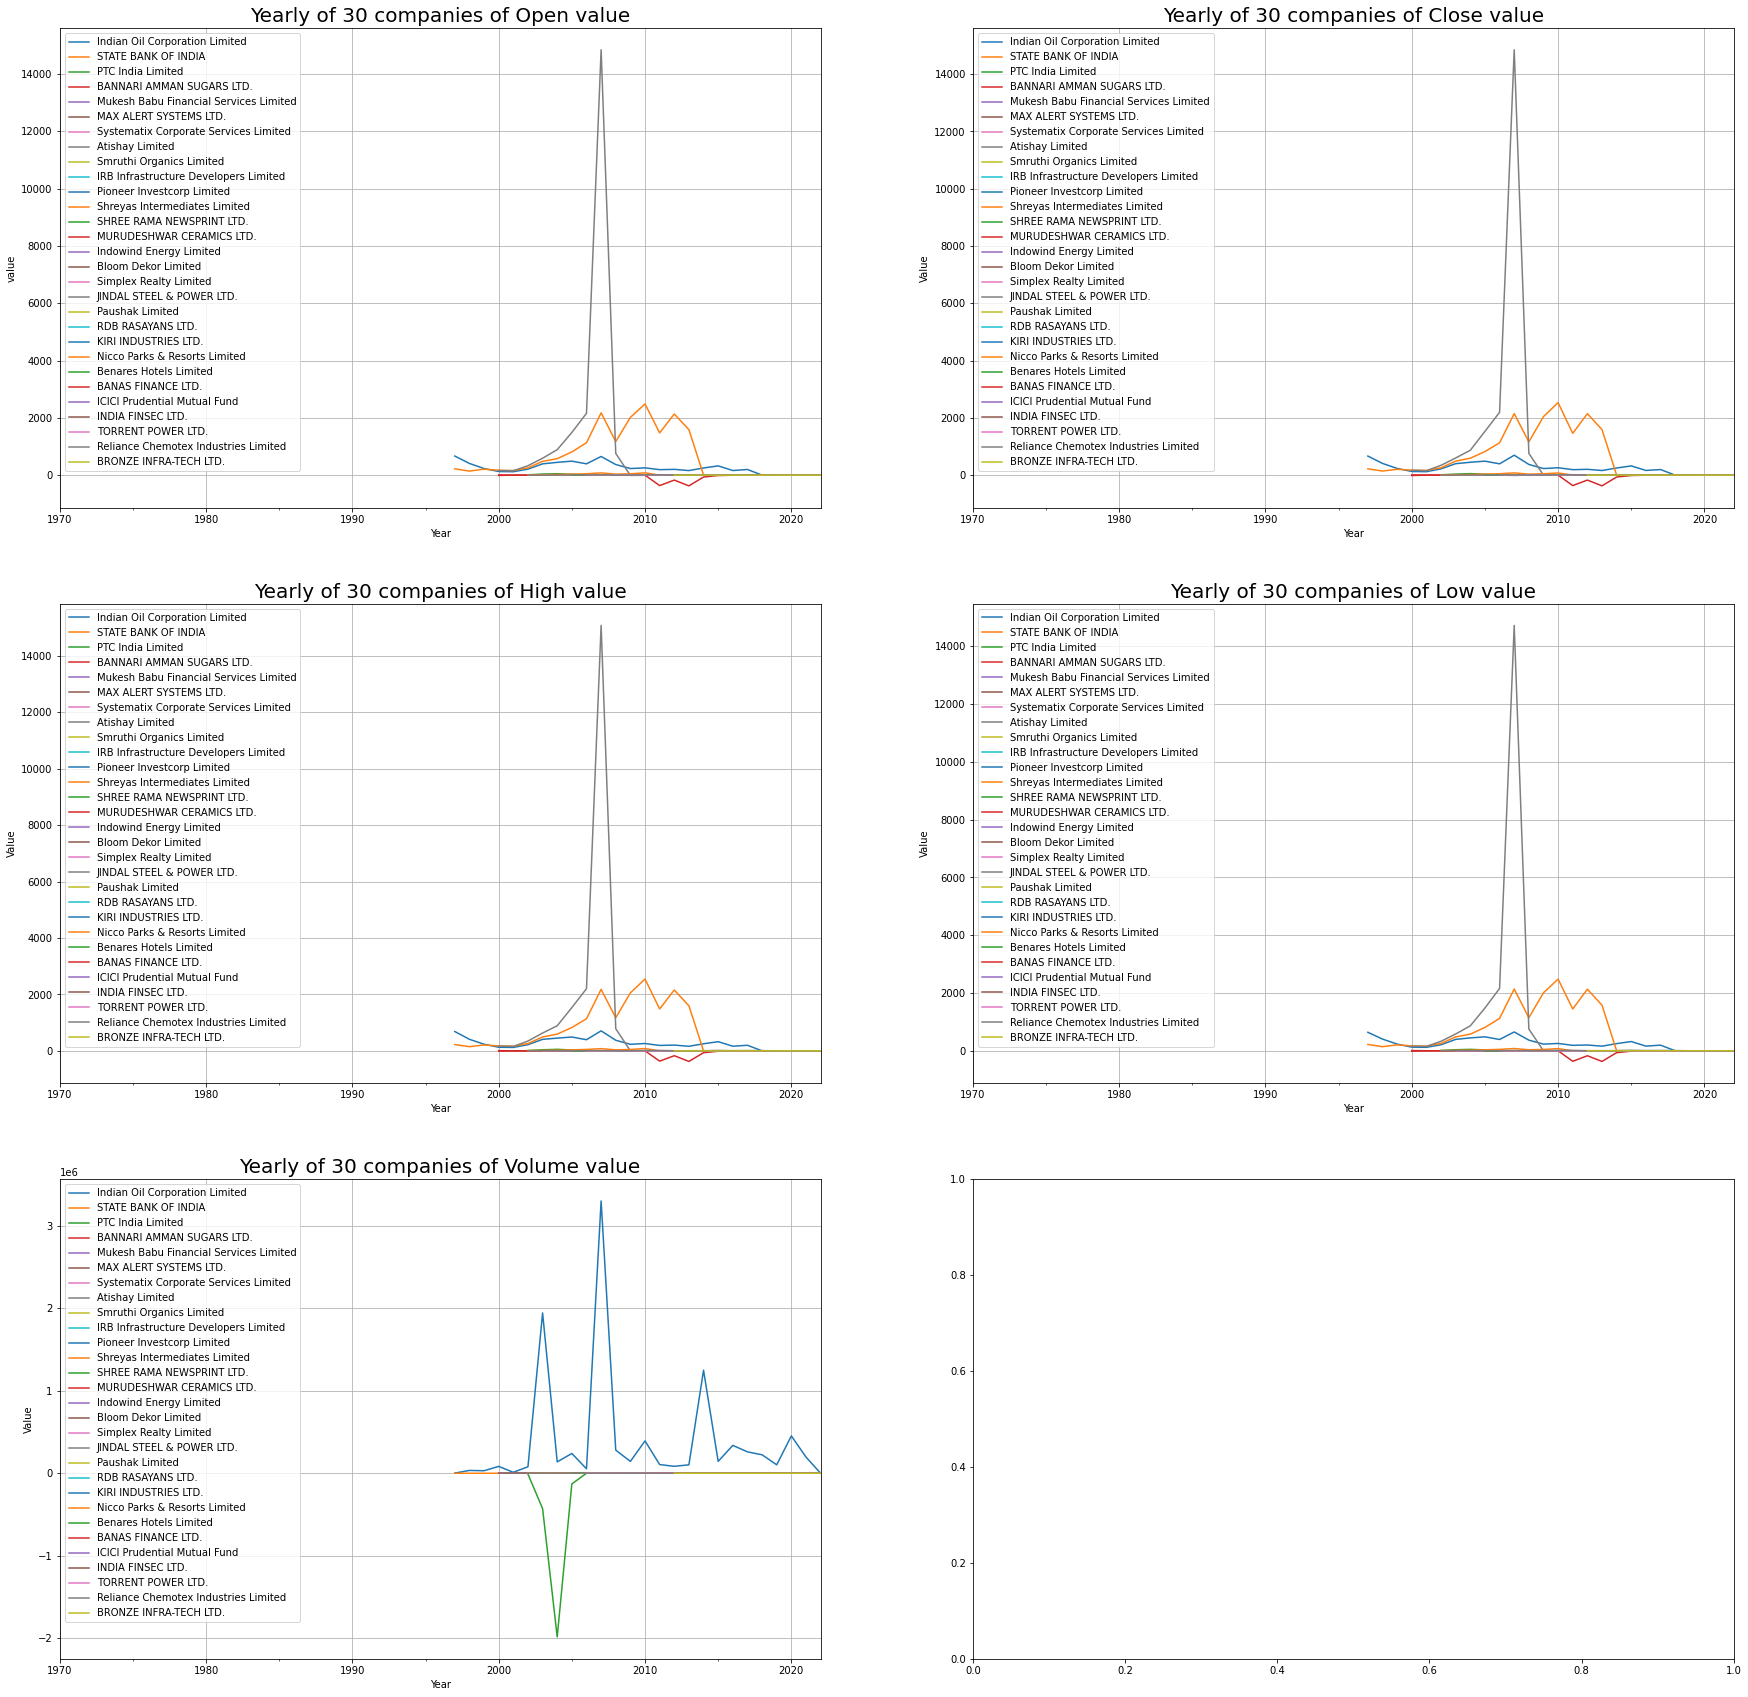

In [357]:
fig, ax = plt.subplots(3,2, figsize=(30,30))

res_open.plot(ax=ax[0][0])
ax[0][0].set_xlabel('Year')
ax[0][0].set_ylabel('value')
ax[0][0].set_title('Yearly of 30 companies of Open value', fontdict={'fontsize':20})
ax[0][0].grid()
ax[0][0].legend(loc=2)

res_close.plot(ax=ax[0][1])
ax[0][1].set_xlabel('Year')
ax[0][1].set_ylabel('Value')
ax[0][1].set_title('Yearly of 30 companies of Close value', fontdict={'fontsize':20})
ax[0][1].grid()
ax[0][1].legend(loc=2)

res_high.plot(ax=ax[1][0])
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('Value')
ax[1][0].set_title('Yearly of 30 companies of High value', fontdict={'fontsize':20})
ax[1][0].grid()
ax[1][0].legend(loc=2)

res_low.plot(ax=ax[1][1])
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('Value')
ax[1][1].set_title('Yearly of 30 companies of Low value', fontdict={'fontsize':20})
ax[1][1].grid()
ax[1][1].legend(loc=2)

res_volume.plot(ax=ax[2][0])
ax[2][0].set_xlabel('Year')
ax[2][0].set_ylabel('Value')
ax[2][0].set_title('Yearly of 30 companies of Volume value', fontdict={'fontsize':20})
ax[2][0].grid()
ax[2][0].legend(loc=2)

### Heatmap
Heatmap of open, close, low, high and volume of 30 companies of yearly data.

#### Heatmap of Open values

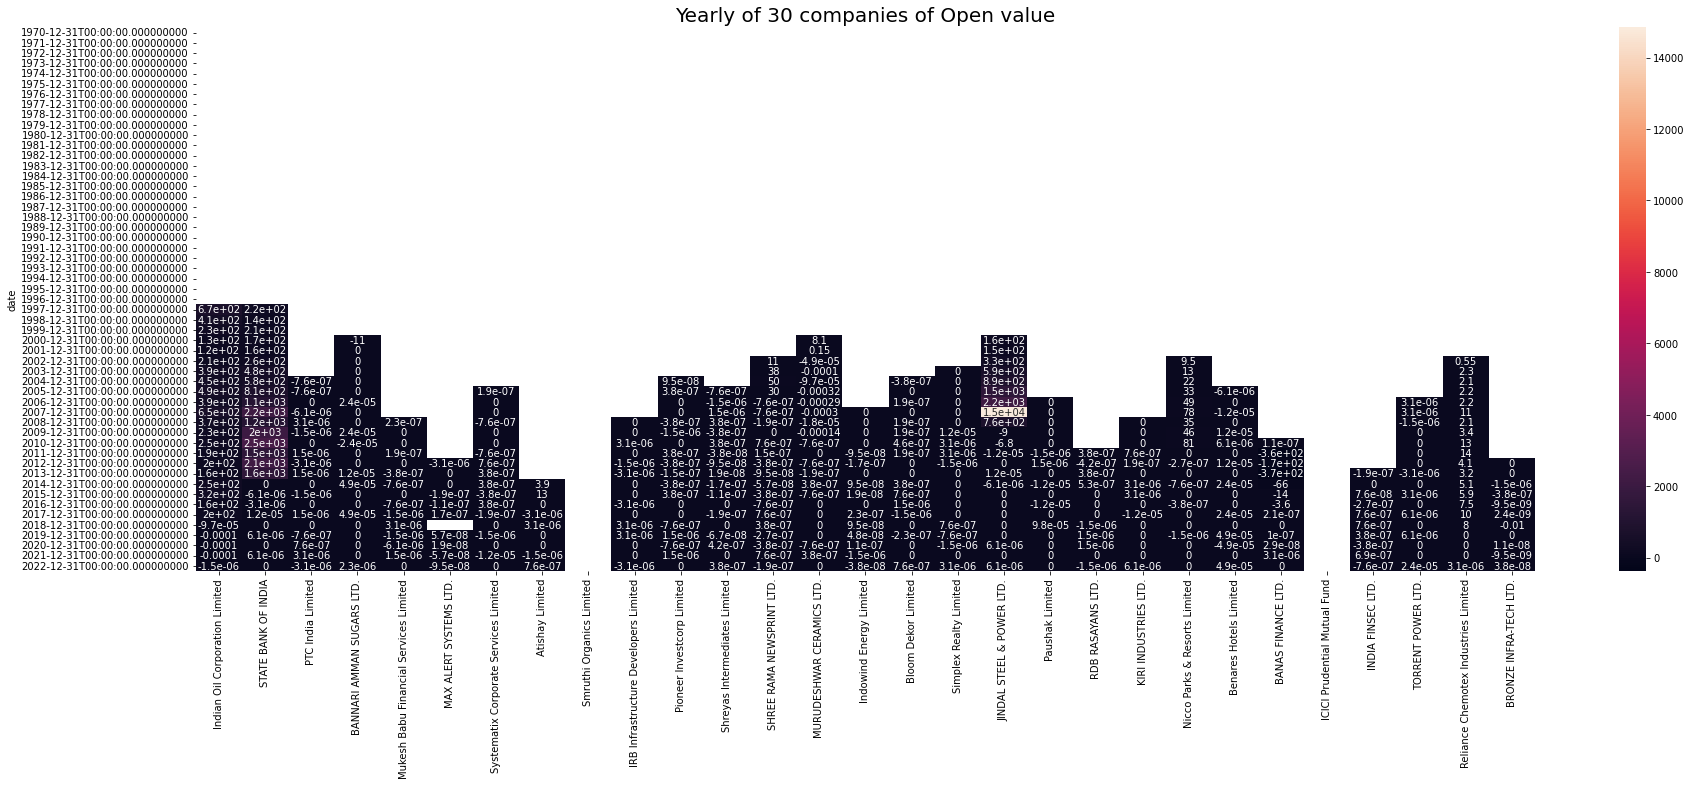

In [358]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(res_open , annot = True)
plt.title('Yearly of 30 companies of Open value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Close values

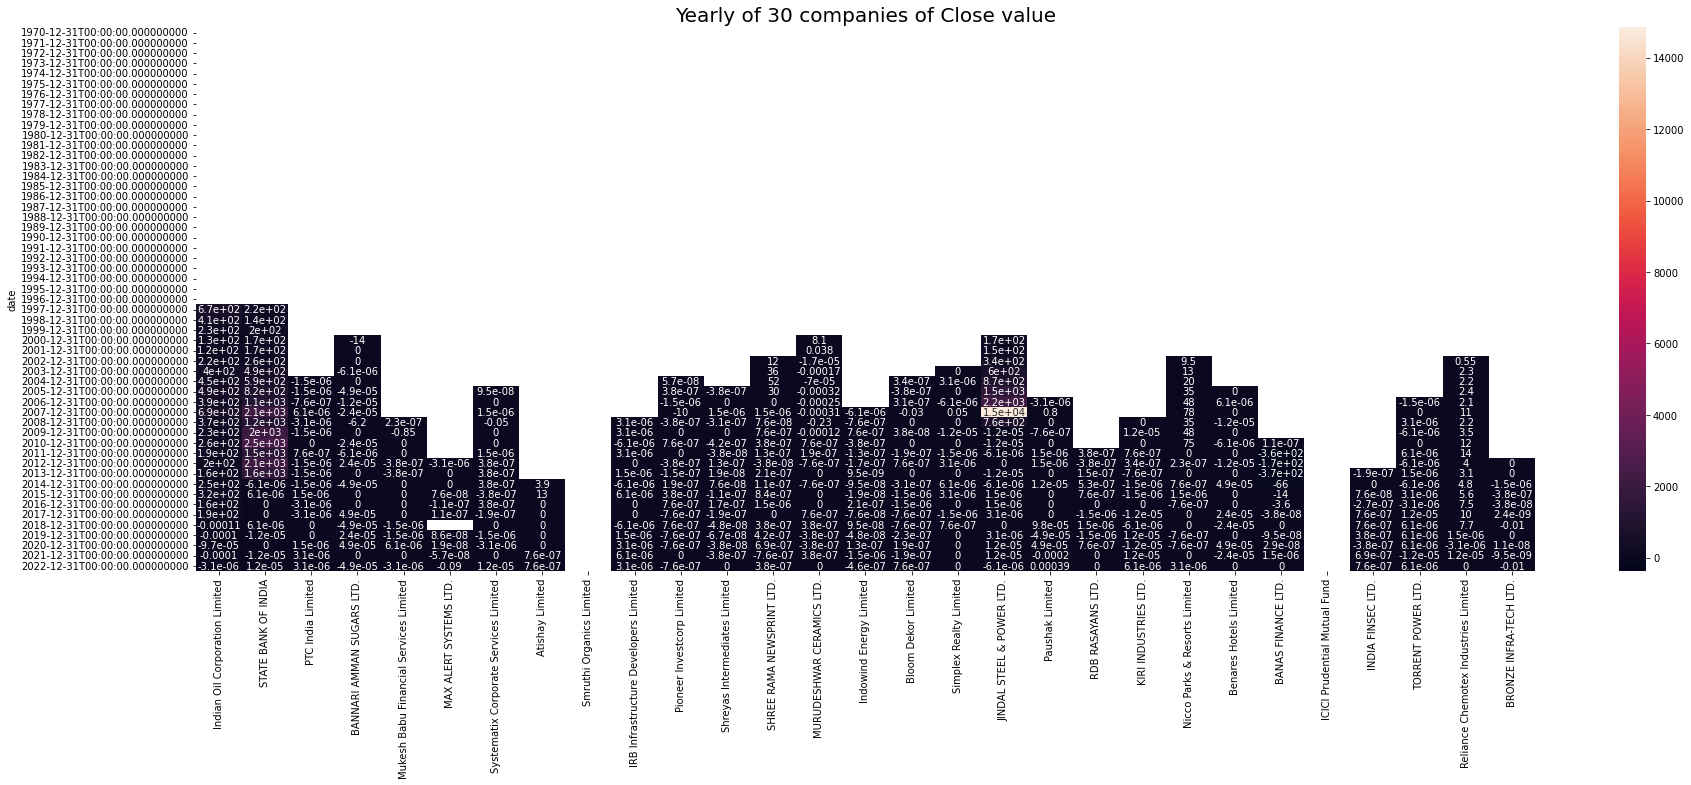

In [361]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(res_close , annot = True)
plt.title('Yearly of 30 companies of Close value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of High values

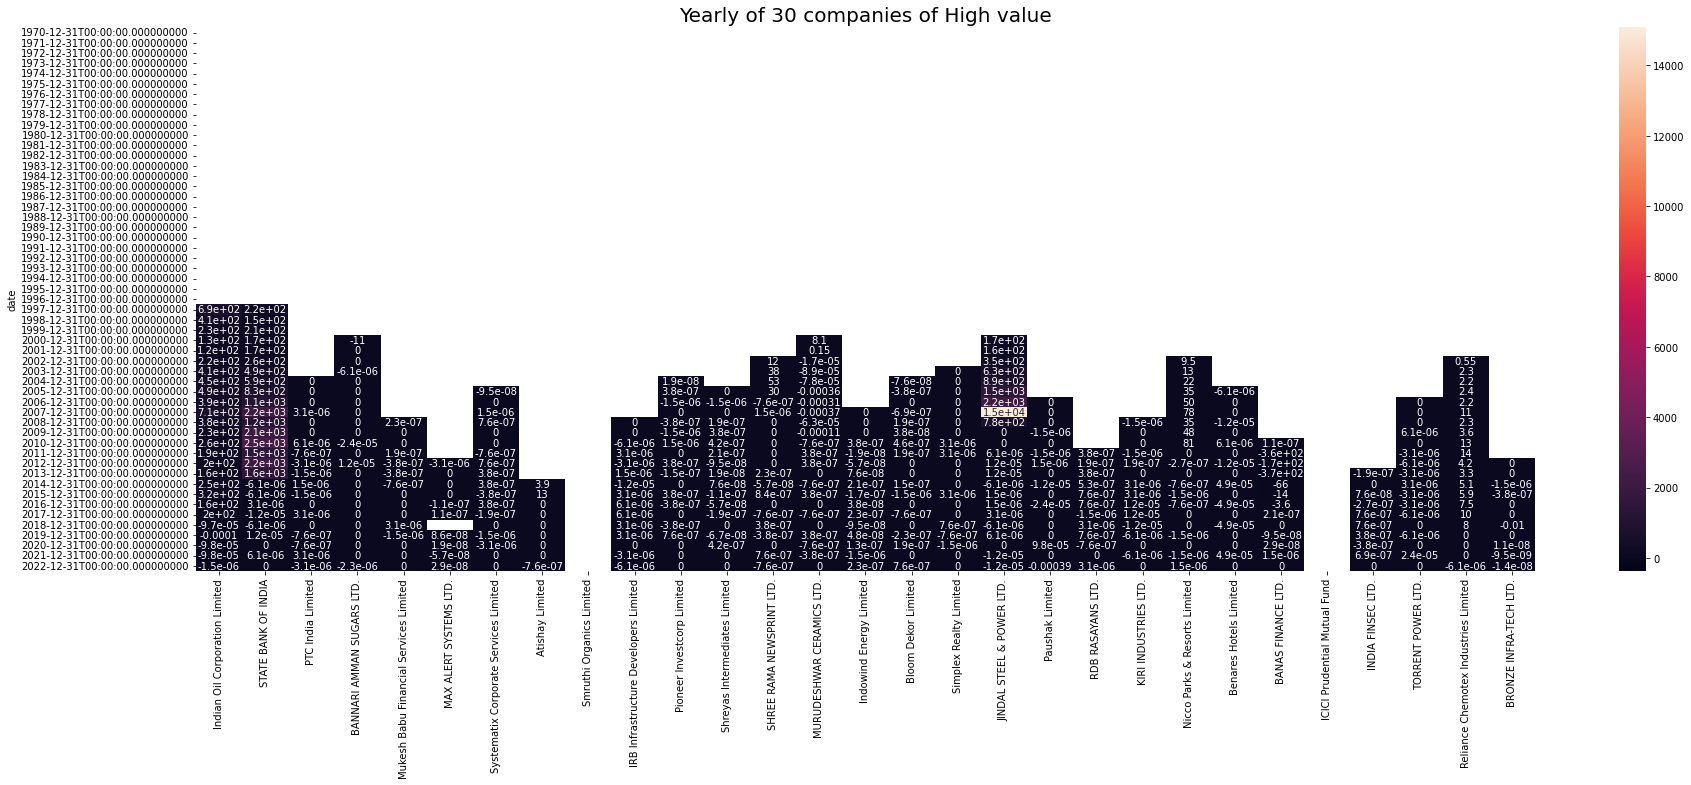

In [359]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(res_high , annot = True)
plt.title('Yearly of 30 companies of High value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Low values

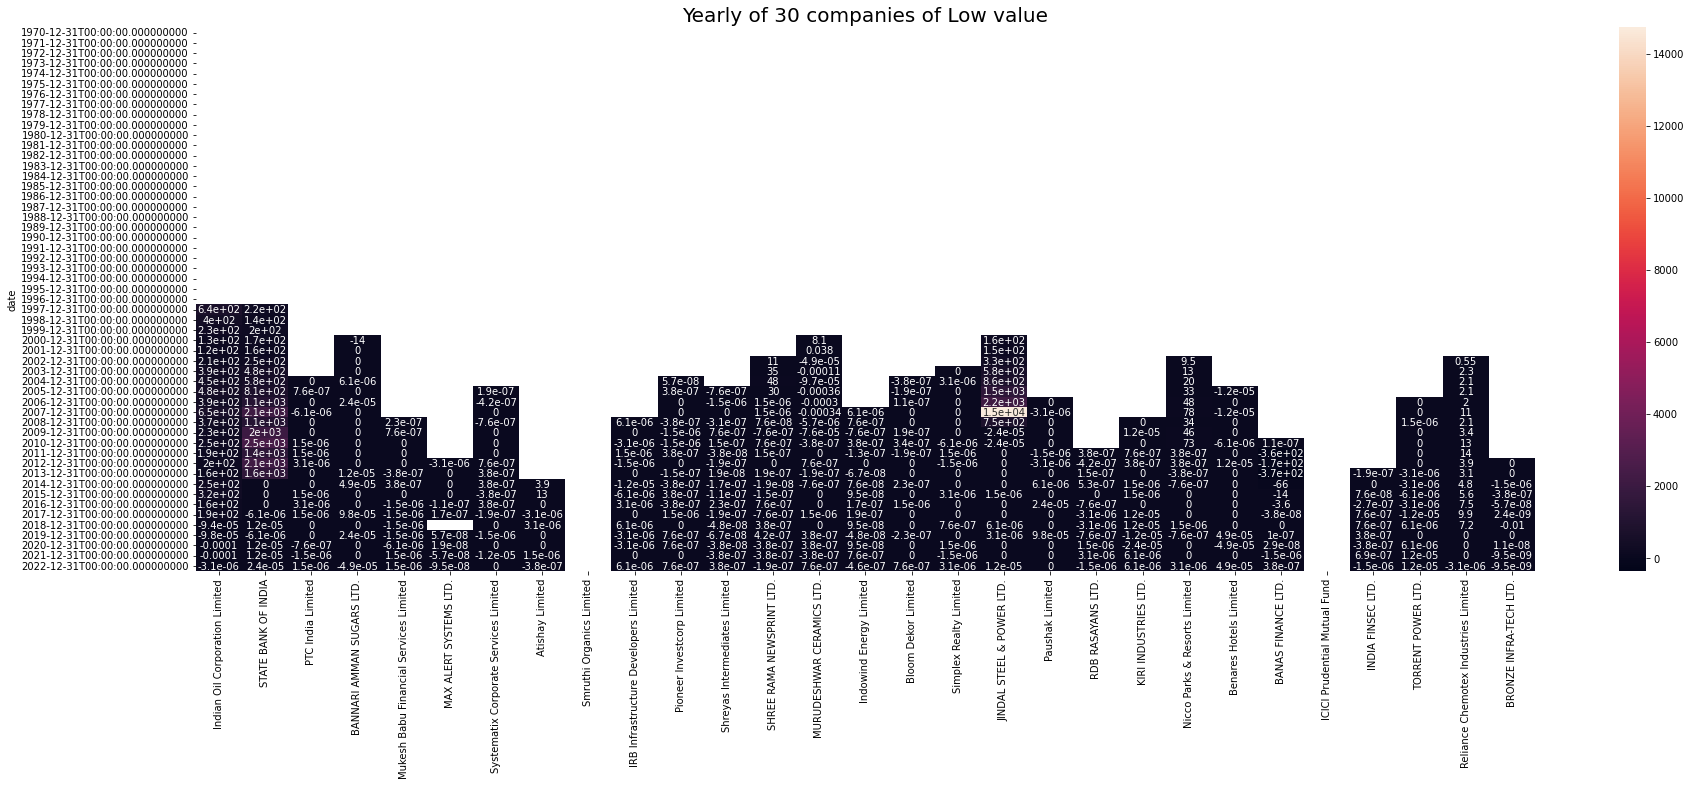

In [360]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(res_low , annot = True)
plt.title('Yearly of 30 companies of Low value', fontdict={'fontsize':20})
plt.show()

#### Heatmap of Volume values

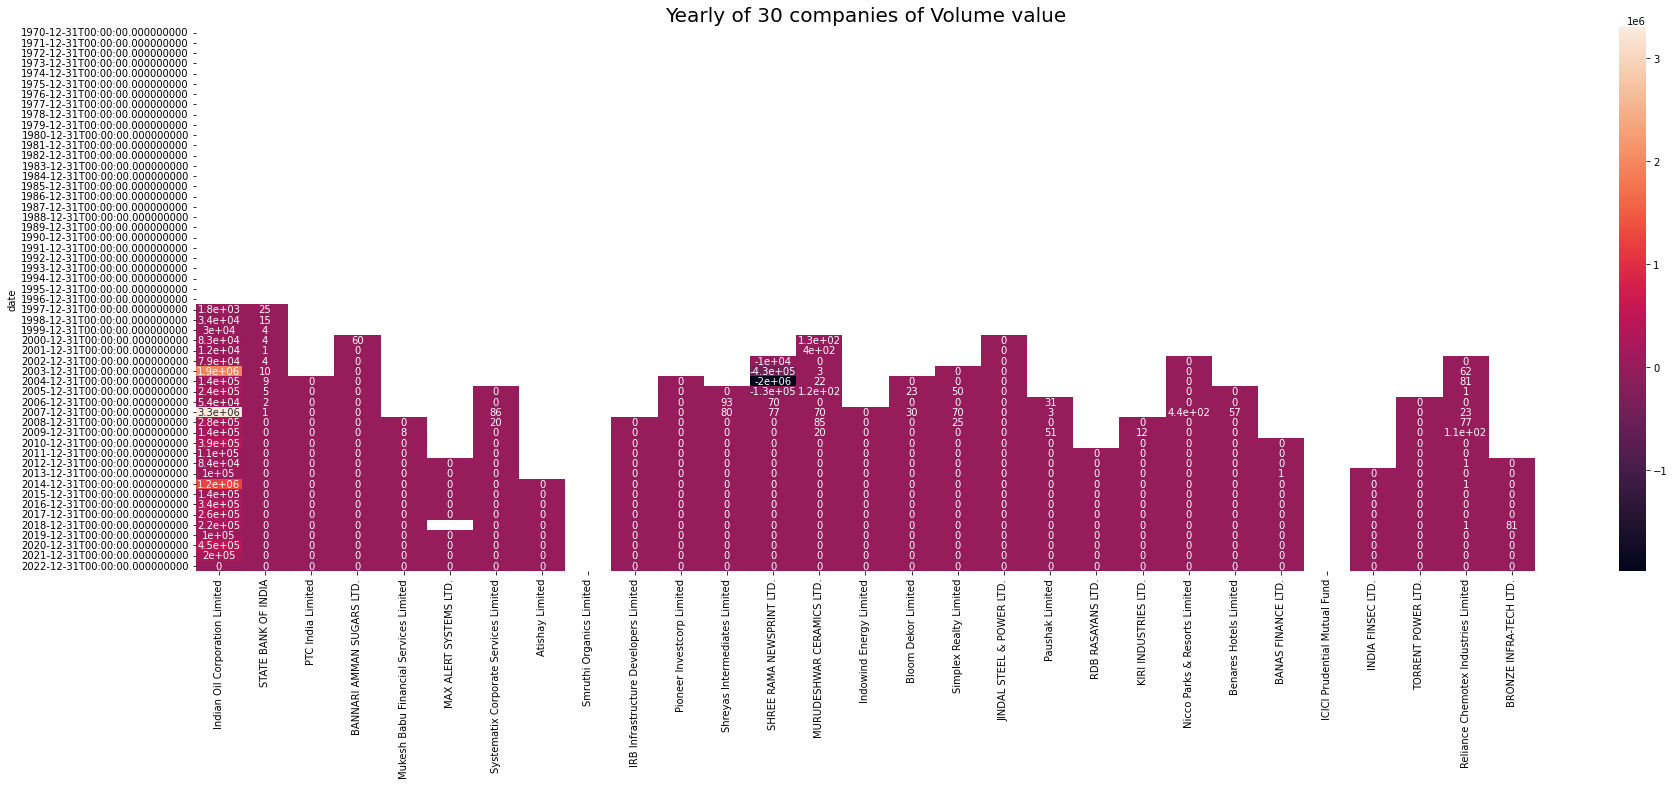

In [ ]:
import seaborn as sns
plt.figure(figsize=(30, 10))
ax = sns.heatmap(res_volume , annot = True)
plt.title('Yearly of 30 companies of Volume value', fontdict={'fontsize':20})
plt.show()

### Exploring correlaltion among data
Here, we will explore correlation among data using correlation matrix then we will plot that on heatmap.

#### Correlation plot for open values

<AxesSubplot:>

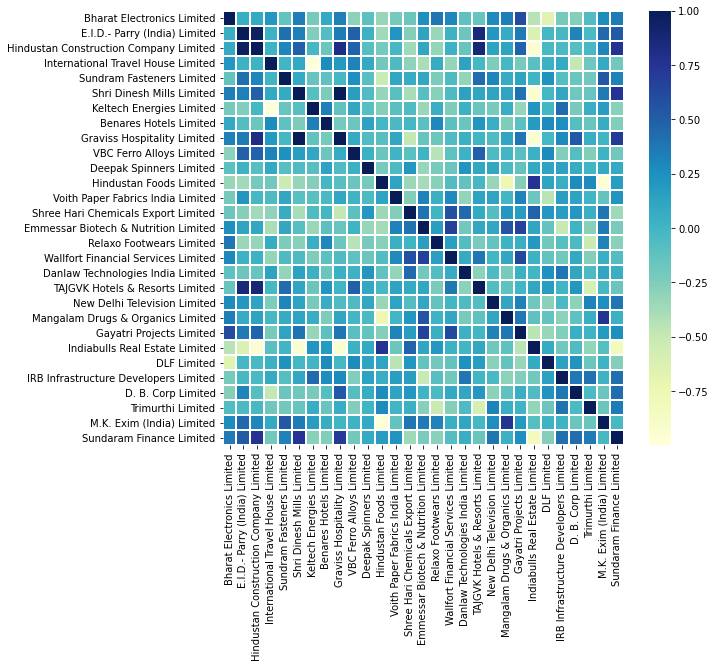

In [30]:
corrmat = res_open.corr()
  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

#### Correlation plot for close values

<AxesSubplot:>

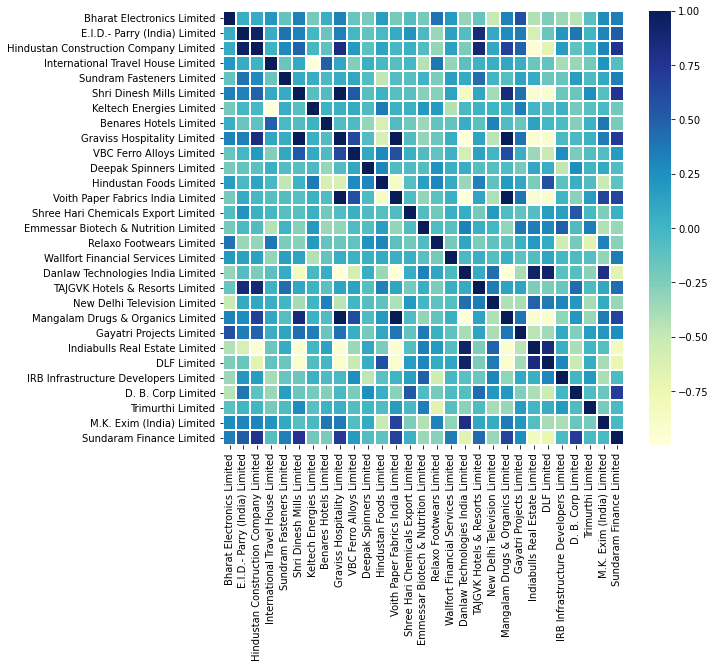

In [34]:
corrmat = res_close.corr()
  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

#### Correlation plot for high values

<AxesSubplot:>

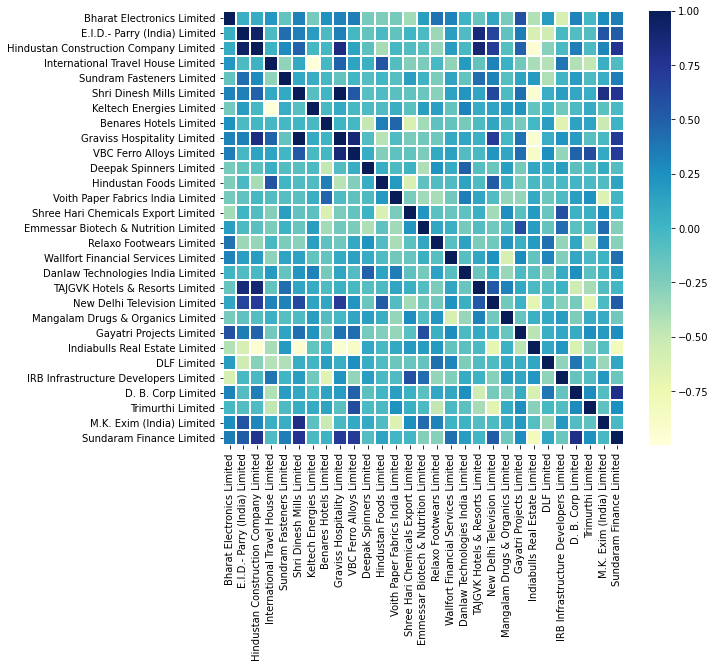

In [33]:
corrmat = res_high.corr()
  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

### Correlation plot for low values

<AxesSubplot:>

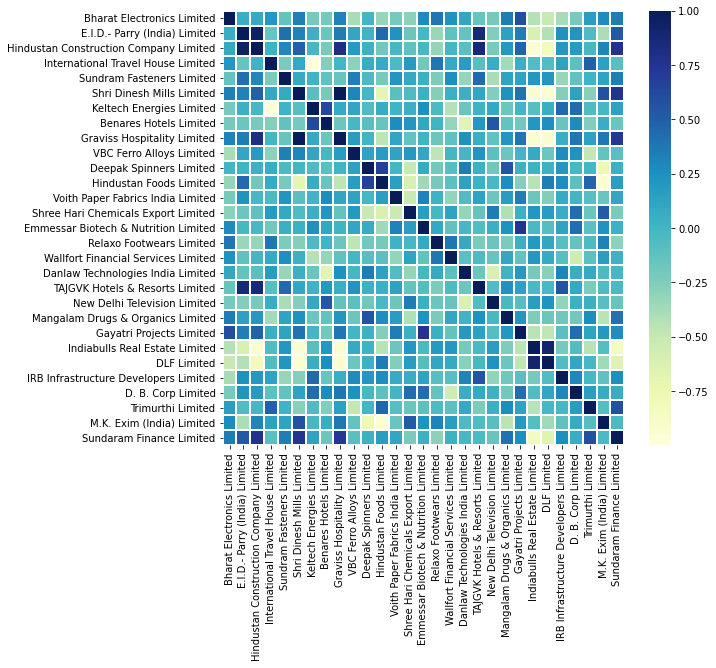

In [32]:
corrmat = res_low.corr()
  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

#### Correlation plot for volume values

<AxesSubplot:>

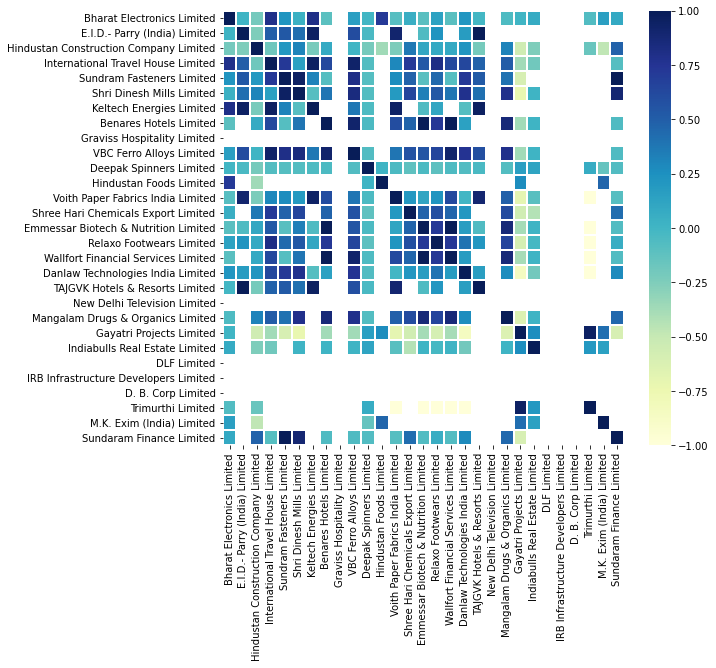

In [31]:
corrmat = res_volume.corr()
  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

# Conclusion

|yfinance|EODHistorical data|
|:---:|:---:|
|No missing data.|No missing data.|
|No duplicate values|No duplicate values|

**Eodhistorical data has slight higher values than yfinance data values.**